In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

# Data

In [2]:
data_train = pd.read_csv('../data/landmark_train.csv', header = None)
data_train.rename(columns={0: 'class'}, inplace=True)

data_val = pd.read_csv('../data/landmark_val.csv', header = None)
data_val.rename(columns={0: 'class'}, inplace=True)

data_test = pd.read_csv('../data/landmark_test.csv', header = None)
data_test.rename(columns={0: 'class'}, inplace=True)

In [3]:
data_train.head()

,class,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,0.288451,0.755826,-1.641675e-07,0.343430,0.610872,0.007127,0.338774,0.483970,0.012900,...,0.002779,0.166552,0.572639,0.017464,0.187247,0.594405,0.027215,0.197301,0.627522,0.031852
1,0,0.284355,0.758424,-1.626656e-07,0.340084,0.618892,0.005401,0.338207,0.493161,0.010639,...,0.002941,0.161730,0.581962,0.017628,0.182382,0.603506,0.027834,0.192918,0.633507,0.032845
2,0,0.772540,0.873969,-4.093911e-07,0.806356,0.753379,0.039669,0.809349,0.655948,0.044010,...,-0.051426,0.680994,0.618226,-0.028830,0.682399,0.657748,-0.008405,0.692334,0.687387,0.001152
3,0,0.772382,0.874898,-4.724001e-07,0.805449,0.756308,0.048195,0.809278,0.656744,0.055078,...,-0.056545,0.683569,0.617887,-0.028079,0.684179,0.657855,-0.005880,0.693053,0.688468,0.003123
4,0,0.774203,0.874685,-4.511580e-07,0.807134,0.754932,0.047895,0.810559,0.656776,0.054485,...,-0.055454,0.684528,0.616954,-0.027446,0.685310,0.657239,-0.005036,0.694569,0.687970,0.004399


In [4]:
data_train['class'].value_counts(), data_val['class'].value_counts(), data_test['class'].value_counts()
# Balanced dataset

(class
 3    336
 4    301
 2    292
 1    260
 0    248
 Name: count, dtype: int64,
 class
 4    189
 3    175
 2    146
 0    145
 1    137
 Name: count, dtype: int64,
 class
 3    158
 4    154
 1    142
 2    132
 0    122
 Name: count, dtype: int64)

In [5]:
# Convert dataframe to array
X_train = data_train.iloc[:, 1:].values
y_train = data_train.iloc[:, 0].values

X_val = data_val.iloc[:, 1:].values
y_val = data_val.iloc[:, 0].values

X_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:, 0].values

In [6]:
X_train.shape, y_train.shape

((1437, 63), (1437,))

# Normalize data

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
joblib.dump(scaler, 'scaler.pkl')

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((1437, 63), (708, 63), (792, 63), (1437,), (708,), (792,))

In [8]:
# Convert nparray to tensor because torch only accepts tensor and we need to use neural network
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Build DataLoader

In [9]:
batch_size = 64

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
        
training_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
val_data = CustomDataset(X_val, y_val)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Build MLP Model

In [11]:
from typing import Literal, Optional
import math
import random
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layer, output_size):
        super().__init__()
        
        # Set up layers
        layers = [
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.1)
        ]
        
        for _ in range(hidden_layer - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.LeakyReLU(0.1))
        
        layers.append(nn.Linear(hidden_size, output_size))

        self.classifier = nn.Sequential(*layers)
        
        # # Initialize weights
        # for layer in self.classifier:
        #     if isinstance(layer, nn.Linear):
        #         nn.init.xavier_uniform_(layer.weight)
        #         if layer.bias is not None:
        #             nn.init.zeros_(layer.bias)

        # Initialize weights
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='leaky_relu')  # or 'leaky_relu'
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, X):
        output = self.classifier(X)
        return output
    
    def predict(self,x,threshold=0.9):
        logits = self(x)
        softmax_prob = nn.Softmax(dim=1)(logits)
        # print(softmax_prob)
        max_probs, chosen_inds = torch.max(softmax_prob, dim=1)
        print(max_probs, chosen_inds)
        return torch.where(max_probs>0.9,chosen_inds,-1)

# Training Session

In [12]:
train_lossess = []
val_lossess = []
f1_train = []
f1_val = []

In [13]:
epochs = 150

input_size = X_train.shape[1]
hidden_size = 100

hidden_layer = 3
output_size = len(torch.unique(y_train))
model = NeuralNetwork(input_size, hidden_size, hidden_layer, output_size)

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

model

NeuralNetwork(
  (classifier): Sequential(
    (0): Linear(in_features=63, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=100, out_features=5, bias=True)
  )
)

In [14]:
best_f1_val = 0.0
best_model_state = None

train_lossess = []
val_lossess = []
f1_train = []
f1_val = []

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0

    y_train_label_pred = []
    y_train_label_true = []

    y_val_label_pred = []
    y_val_label_true = []

    # Training session
    model.train()
    for X_train, y_train in train_loader:
        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        y_pred = model(X_train)

        # Compute loss
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()

        # Predictions
        y_train_label_true.extend(y_train.tolist())
        y_train_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

        # Backpropagation
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_lossess.append(train_loss)

    f1_score_train = f1_score(y_train_label_true, y_train_label_pred, average='macro')
    f1_train.append(f1_score_train)

    # Validation session
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()

            y_val_label_true.extend(y_val.tolist())
            y_val_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

        val_loss /= len(val_loader)
        val_lossess.append(val_loss)

        f1_score_val = f1_score(y_val_label_true, y_val_label_pred, average='macro')
        f1_val.append(f1_score_val)

        # Save best model based on validation F1 score
        if f1_score_val > best_f1_val:
            best_f1_val = f1_score_val
            best_model_state = model.state_dict()
            print(f"Epoch {epoch+1}: New best F1 on val = {f1_score_val:.4f}, saving model...")
        
        scheduler.step()

# After training, save the best model weights to a file
torch.save(best_model_state, 'best_model.pth')
print("Training complete. Best model saved as 'best_model.pth'")

Epoch 1: New best F1 on val = 0.8986, saving model...
Epoch 2: New best F1 on val = 0.9405, saving model...
Epoch 3: New best F1 on val = 0.9641, saving model...
Epoch 4: New best F1 on val = 0.9972, saving model...
Epoch 5: New best F1 on val = 0.9986, saving model...
Training complete. Best model saved as 'best_model.pth'


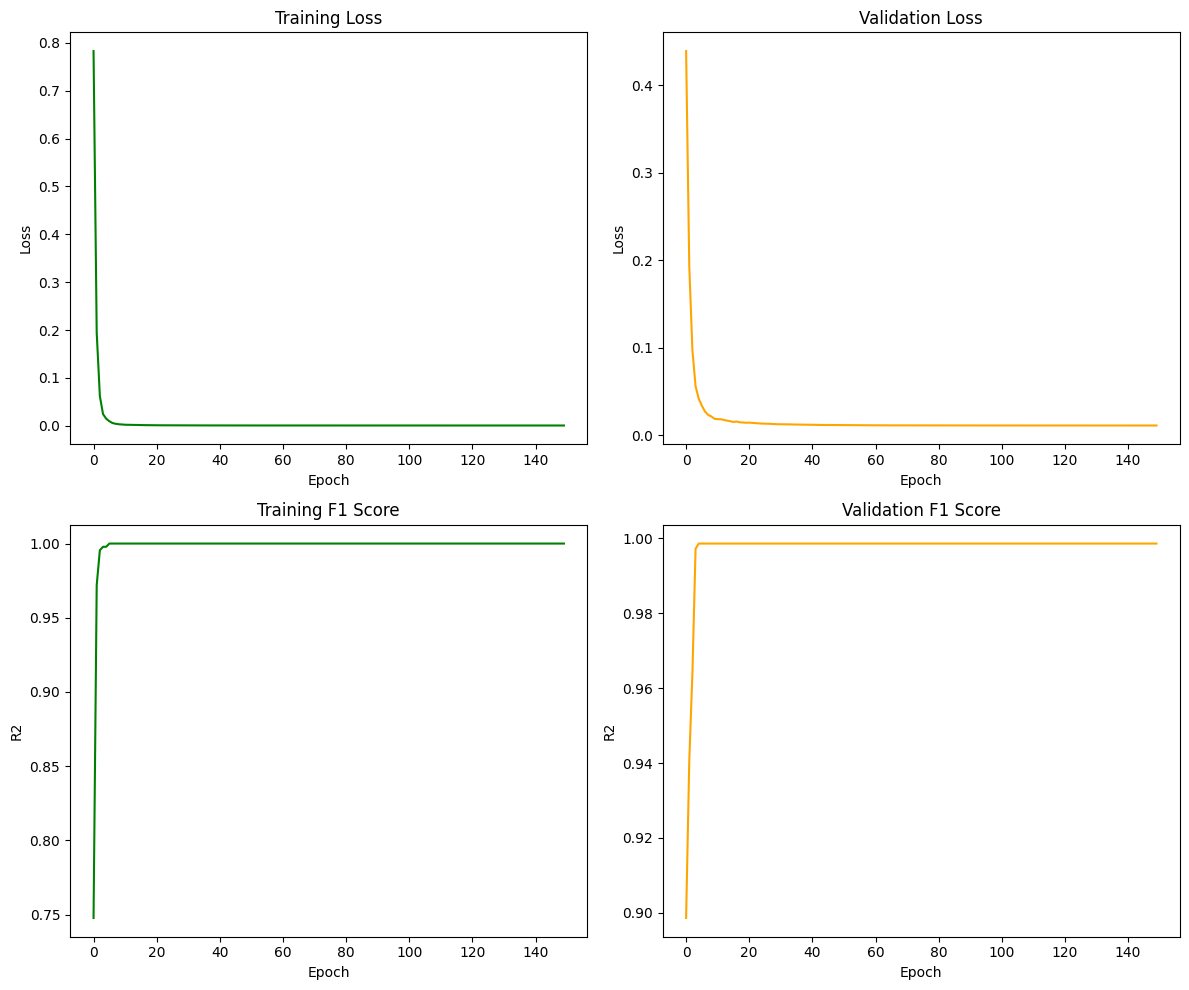

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_lossess, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_lossess, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(f1_train, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training F1 Score')

ax[1, 1].plot(f1_val, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation F1 Score')
plt.tight_layout()

plt.show()

# Evaluation

In [16]:
best_model_state = torch.load('best_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(best_model_state)

/var/folders/tj/fhptpgmj2dv2nwb43c0_06540000gp/T/ipykernel_45227/4221509565.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load('best_model.pth

<All keys matched successfully>

In [17]:
model.eval()
y_test_label_true = []
y_test_label_pred = []
test_loss = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        # forward pass
        logit = model(X_test)
        softmax_prob = torch.softmax(logit, dim=1)
        max_probs, chosen_inds = torch.max(softmax_prob, dim=1)
     
        y_pred = torch.where(max_probs>0.9,chosen_inds,-1)
       
        # calculate loss
        loss = criterion(logit, y_test)
        test_loss += loss.item()

        # concat
        y_test_label_true.extend(y_test.tolist())
        y_test_label_pred.extend(y_pred.tolist())

    test_loss /= len(test_loader)
    
    f1_score_test = f1_score(y_test_label_true, y_test_label_pred, average='macro')

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {f1_score_test:.4f}')

Test Loss: 0.0110
Test Accuracy: 0.8247
